3.2 简单的word2vec

CBOW模型的推理

In [14]:
#MatMul节点的反向传播
class MatMul:
    def __init__(self,W):
        self.params=[W]
        self.grads=[np.zeros_like(W)]   #构造一个矩阵self.grads，其维度与矩阵W一致，并为其初始化为全0
        self.x=None
        
    def forward(self,x):
        W,=self.params
        out=np.dot(x,W)
        self.x=x
        return out
    
    def backward(self,dout):
        W,=self.params
        dx=np.dot(dout,W.T)
        dW=np.dot(self.x.T,dout)
        self.grads[0][...]=dW
        return dx
    

In [15]:
#样本的上下文数据
c0=np.array([[1,0,0,0,0,0,0]])
c1=np.array([[0,0,1,0,0,0,0]])

#权重的初始值
W_in=np.random.randn(7,3)  #输入侧共享权重W_in
W_out=np.random.randn(3,7)

#生成层
in_layer0=MatMul(W_in)
in_layer1=MatMul(W_in)
out_layer=MatMul(W_out)

#正向传播
h0=in_layer0.forward(c0)
h1=in_layer1.forward(c1)
h=0.5*(h0+h1)
s=out_layer.forward(h)  #通过输出侧的MatMul层计算各个单词的得分

print(s)

[[ 0.08270981  0.00305801  0.28820887  0.74154835 -0.62078351  0.45960527
  -0.17517667]]


#学习数据的准备

In [16]:
import sys

import numpy as np

sys.path.append('..')
from common.util import preprocess

text='You say goodbye and I say hello.'
corpus,word_to_id,id_to_word=preprocess(text)

print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [17]:
#从corpus列表生成contexts和target,生成上下文和目标词的函数
def create_contexts_target(corpus,window_size=1):
    target=corpus[window_size:-window_size]
    contexts=[]

    for idx in range(window_size,len(corpus)-window_size):
        cs=[]
        for t in range(-window_size,window_size+1):
            if t==0:
                continue
            cs.append(corpus[idx+t])
        contexts.append(cs)
    return np.array(contexts),np.array(target)

In [18]:
contexts,target=create_contexts_target(corpus,window_size=1)
print(contexts)#将语料库分成上下文
print(target)#将语料库分成目标词

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


In [19]:
#将目标词转为one-hot形式
from common.util import convert_one_hot
vocab_size=len(word_to_id)
target=convert_one_hot(target,vocab_size)
contexts=convert_one_hot(contexts,vocab_size)
print(target)
print(contexts)

[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]


#神经网络实现SimpleCBOW类

In [20]:
from common.layers import SoftmaxWithLoss,MatMul
class SimpleCBOW:
    def __init__(self,vocab_size,hidden_size):
        V,H=vocab_size,hidden_size

        #初始化权重
        W_in=0.01*np.random.randn(V,H).astype('f')  #通过astype()方法强制转换数据的类型
        W_out=0.01*np.random.randn(H,V).astype('f')

        #生成层
        self.in_layer0=MatMul(W_in)#用来处理输入侧上下文的MatMul层的数量与上下文单词数量相等
        self.in_layer1=MatMul(W_in)
        self.out_layer=MatMul(W_out)
        self.loss_layer=SoftmaxWithLoss()

        #将所有权重和梯度整理到列表里
        layers=[self.in_layer0,self.in_layer1,self.out_layer]
        self.params,self.grads=[],[]
        for layer in layers:
            self.params+=layer.params
            self.grads+=layer.grads

        #将单词的分布式表示设置为成员变量
        self.word_vecs=W_in

    #实现正向传播，接收contexts和target并返回损失
    def forward(self,contexts,target):#contexts是一个三维数组（6,2,7），第0维的元素个数是mini-batch数量，第1维元素个数是上下文窗口大小，第2维表示one-hot向量
        h0=self.in_layer0.forward(contexts[:,0])
        h1=self.in_layer1.forward(contexts[:,1])
        h=0.5*(h0+h1)
        score=self.out_layer.forward(h)
        loss=self.loss_layer.forward(score,target)
        return loss

    #反向传播更新各个权重的梯度
    def backward(self,dout=1):
        ds=self.loss_layer.backward(dout)
        da=self.out_layer.backward(ds)
        da*=0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

#CBOW学习的实现

| epoch 1 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 2 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 3 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 4 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 5 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 6 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 7 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 8 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 9 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 10 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 11 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 12 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 13 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 14 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 15 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 16 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 17 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 18 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 19 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 20 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 21 |  iter 1 / 2 | ti

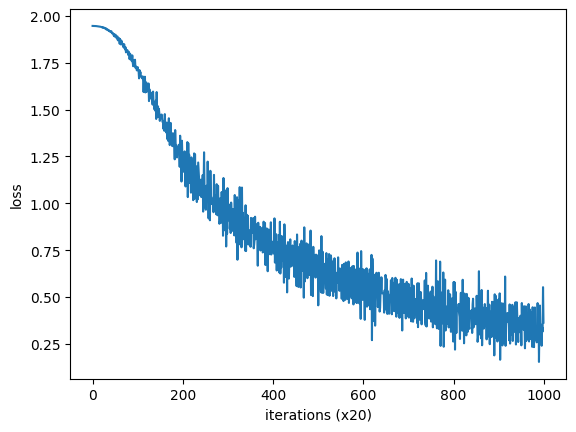

In [21]:
from common.trainer import Trainer
from common.optimizer import Adam

#定义超参数
window_size=1
hidden_size=5
batch_size=3
max_epoch=1000

text="You say goodbye and I say hello."
corpus,word_to_id,id_to_word=preprocess(text)

vocab_size=len(word_to_id)
contexts,target=create_contexts_target(corpus,window_size)
target=convert_one_hot(target,vocab_size)
contexts=convert_one_hot(contexts,vocab_size)

model=SimpleCBOW(vocab_size,hidden_size)
optimizer=Adam()
trainer=Trainer(model,optimizer)
trainer.fit(contexts,target,max_epoch,batch_size)
trainer.plot()


In [22]:
#查看学习后的权重参数,当神经网络训练结束后，其隐藏层的权重就是我们要的每个词的词向量
word_vecs=model.word_vecs#保存权重
for word_id,word in id_to_word.items():
    print(word,word_vecs[word_id])

you [-1.6867068   0.8431766  -0.84971994  0.8452314  -0.9251832 ]
say [-0.44928768 -1.2644027   1.2436727  -1.1987497   0.32939172]
goodbye [ 0.31273693  1.025188   -1.0453187   1.0642195  -1.1357472 ]
and [-1.5585575  -0.91563624  0.88699836 -0.8930315   1.5455444 ]
i [ 0.32596737  1.0362525  -1.0461327   1.0678108  -1.1408917 ]
hello [-1.6871629   0.85577303 -0.8442578   0.8356418  -0.92154855]
. [ 1.4623855 -1.1590834  1.1784228 -1.1158795 -1.6385888]
